# Figure 3

In [1]:
# Import packages.
import allel
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import zarr
# Print version numbers.
print('allel', allel.__version__)
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('zarr', zarr.__version__)

allel 1.3.5
matplotlib 3.5.2
numpy 1.22.3
pandas 1.4.2
zarr 2.11.3


In [2]:
# Intialize the matplolib styling.
plt.rcParams.update({
    'figure.constrained_layout.use': True,
    'figure.facecolor': 'white',
    'font.family': 'serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
})

In [3]:
# Define a function to exctract a genotype matrix for a specific haplotype region.
def load_hap_region():
    # Intialize the file path.
    path = './data/tgp_mod_arc_anc_748kb.zarr'
    # Load the zarr array.
    zarr_array = zarr.open_group(path, mode='r')
    # Extract the genotype callset.
    chr_callset = zarr_array['12/calldata/GT']
    # Load the positions.
    chr_pos = allel.SortedIndex(zarr_array['12/variants/POS'])
    # Extract the genotype matrix and positions array.
    hap_loc = chr_pos.locate_range(40758000, 40830000)
    hap_idx = np.where(((40758000 <= chr_pos) & (chr_pos <= 40830000)))[0]
    hap_gt = allel.GenotypeArray(chr_callset[hap_loc])
    hap_pos = chr_pos[hap_idx]
    return hap_gt, hap_pos

In [4]:
# Import the TGP meta data.
tgp_df = pd.read_csv(
    './data/tgp_mod_arc_anc.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Intialize the tgp pop list.
tgp_pop_list = [
    'LWK', 'GWD', 'MSL', 'ESN', 'YRI', # AFR.
    'BEB', 'STU', 'ITU', 'PJL', 'GIH', # SAS.
    'CHB', 'KHV', 'CHS', 'JPT', 'CDX', # EAS.    
    'TSI', 'CEU', 'IBS', 'GBR', 'FIN', # EUR.
    'PEL', 'MXL', 'CLM', 'PUR', # AMR.
]
# Intialize a list of archaic sample names.
arc_list = ['DEN', 'ALT', 'CHA', 'VIN']
# Intialize dictionaries of haplotype identity.
het_hom_rec_int_72kb = {
    'HET': np.loadtxt('./data/72kb_all_het_int_idx.csv', delimiter=',', dtype=int),
    'HOM': np.loadtxt('./data/72kb_all_hom_int_idx.csv', delimiter=',', dtype=int),
    'REC': np.loadtxt('./data/72kb_all_rec_int_idx.csv', delimiter=',', dtype=int),
}

In [5]:
# Load the genotype matrix.
tgp_72kb_gt, _ = load_hap_region()

In [6]:
# Determine the number of heterozygous sites in per ind.
het_array_72kb = tgp_72kb_gt.count_het(axis=0)[:-1]
# Construct a pandas dataframes.
het_72kb_df = pd.DataFrame(
    data={
        'IND': tgp_df['IND'].values[:-1],
        'POP': tgp_df['POP'].values[:-1],
        'Het. Counts': het_array_72kb,
    },
)
# Construct a mask for the Denisovan-like individuals.
het_mask_72kb = np.isin(het_72kb_df.index.values, het_hom_rec_int_72kb['HET'])
hom_mask_72kb = np.isin(het_72kb_df.index.values, het_hom_rec_int_72kb['HOM'])
rec_mask_72kb = np.isin(het_72kb_df.index.values, het_hom_rec_int_72kb['REC'])
den_mask_72kb = np.logical_or.reduce((het_mask_72kb, hom_mask_72kb, rec_mask_72kb))
# Add the masks to the TGP dataframe.
het_72kb_df['Het. Mask'] = het_mask_72kb
het_72kb_df['Hom. Mask'] = hom_mask_72kb
het_72kb_df['Rec. Mask'] = rec_mask_72kb
het_72kb_df['Mask'] = den_mask_72kb
# Extract the archaic information for plotting.
arc_het_counts_72kb = [
    het_72kb_df['Het. Counts'].values[-1],
    het_72kb_df['Het. Counts'].values[-4],
    het_72kb_df['Het. Counts'].values[-3],
    het_72kb_df['Het. Counts'].values[-2],
]
# Intialize lists to store the results per population.
all_het_counts_72kb = []
hum_het_counts_72kb = []
pop_het_mask_72kb = []
pop_hom_mask_72kb = []
pop_den_mask_72kb = []
pop_rec_mask_72kb = []
# For every tgp population...
for pop in tgp_pop_list:
    # Subsetd the dataframe.
    sub_df = het_72kb_df[het_72kb_df['POP'] == pop]
    # Append the lists for plotting.
    all_het_counts_72kb.append(sub_df['Het. Counts'].values)
    hum_het_counts_72kb.append(sub_df[sub_df['Mask'] == False]['Het. Counts'].values)
    pop_het_mask_72kb.append(sub_df['Het. Mask'].values)
    pop_hom_mask_72kb.append(sub_df['Hom. Mask'].values)
    pop_den_mask_72kb.append(sub_df['Mask'].values)
    pop_rec_mask_72kb.append(sub_df['Rec. Mask'].values)

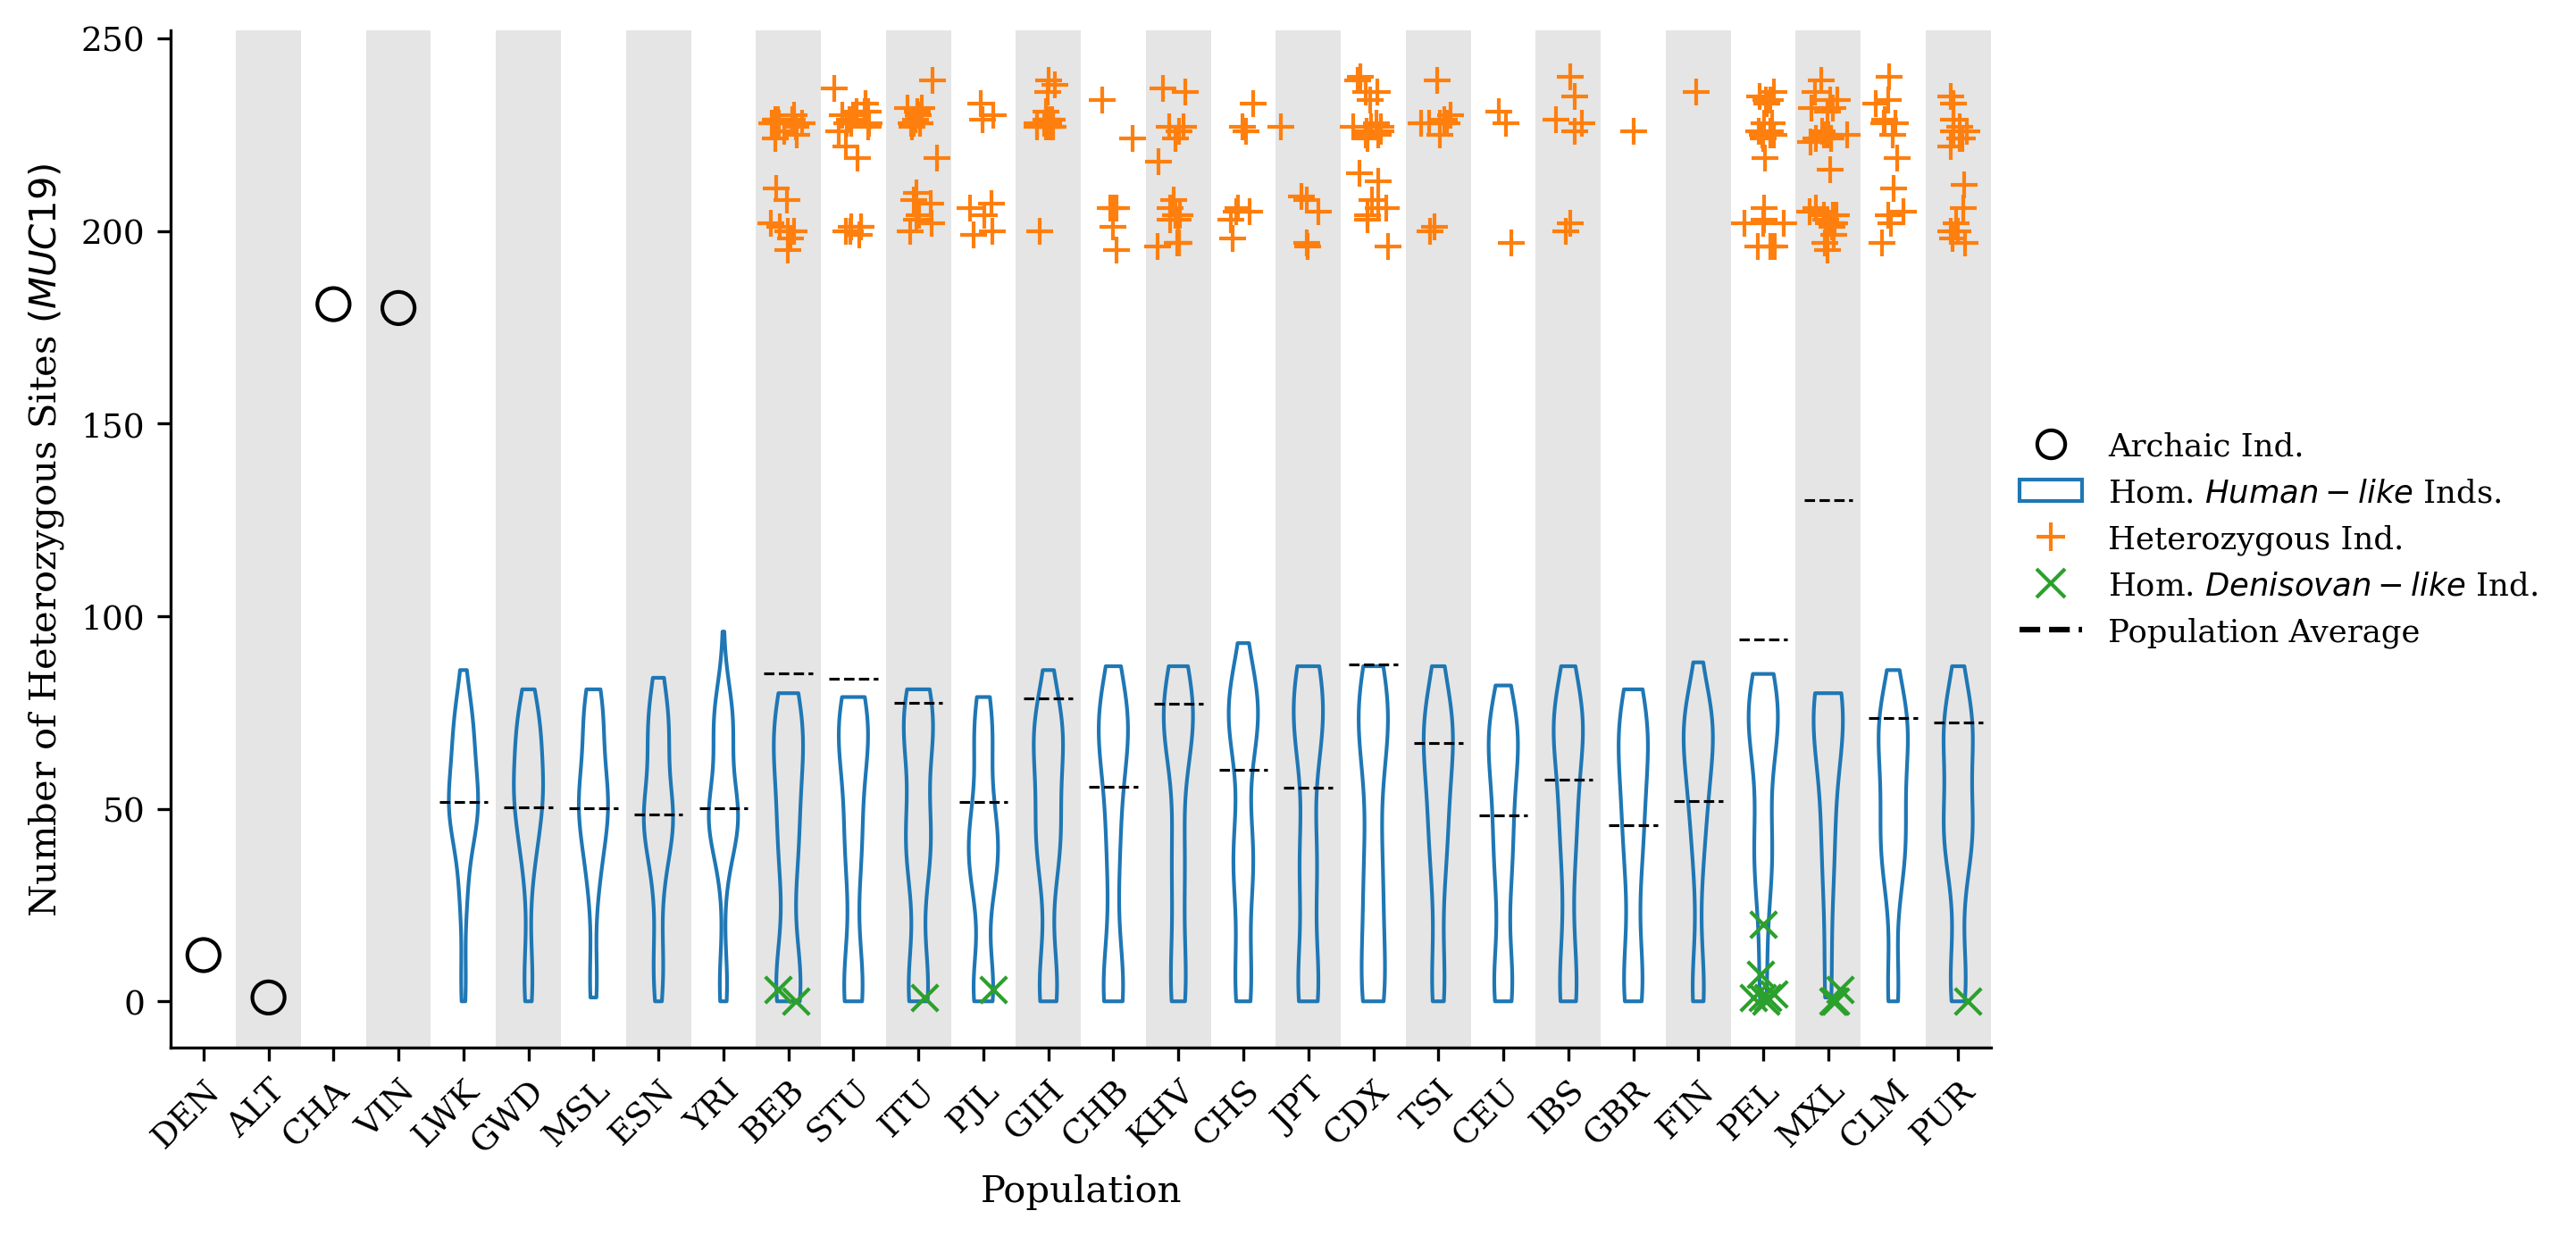

In [7]:
# Intialize the positions to plot.
het_pos = np.arange(0, len(tgp_pop_list)*2+8, 2)
# Intialize a function for plotting the alternating background.
def alt_bands(ax=None):
    locs = np.arange(2, len(tgp_pop_list)*2+8, 4)
    for loc in locs:
        ax.axvspan(loc-1, loc+1, facecolor='black', alpha=0.1)
# Intialize the figure.
fig = plt.figure(
    figsize=(9.5, 4.5), dpi=300,
)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the alternating bands
alt_bands(ax)
# Plot the archaic het sites.
ax.scatter(
    het_pos[:4], arc_het_counts_72kb, color='black',
    marker='o', s=75, linewidths=1, facecolor='none',
)
# Plot the human-like het sites.
vp = ax.violinplot(
    hum_het_counts_72kb, het_pos[4:],
    vert=True, showextrema=False,
    showmeans=False, widths=0.9,
)
# Adjust the violin plots to only show the outline.
for pc in vp['bodies']:
    pc.set_facecolor('none')
    pc.set_edgecolor('tab:blue')
    pc.set_alpha(1)
# For every population...
for idx in range(len(tgp_pop_list)):
    # Extract the positions.
    x_pos = het_pos[4:][idx]
    # Compute the mean.
    het_mean = np.nanmean(all_het_counts_72kb[idx])
    # Plot the mean.
    ax.hlines(
        het_mean, x_pos-0.75, x_pos+0.75,
        colors='black', linestyle='dashed', linewidths=0.75,
    )
# Set the index counter.
idx_counter = 0
# For every x-axis tick.
for i in het_pos[4:]:
    # Grab the data points.
    y = all_het_counts_72kb[idx_counter]
    # Add some jitter to the x-axis.
    x_hets = np.random.normal(i, 0.25, size=len(y[pop_het_mask_72kb[idx_counter]]))
    x_homs = np.random.normal(i, 0.25, size=len(y[pop_hom_mask_72kb[idx_counter]]))
    # Plot the points!
    ax.scatter(
        x_hets, y[pop_het_mask_72kb[idx_counter]],
        color='tab:orange', marker='+', s=50, linewidths=1,
    )
    ax.scatter(
        x_homs, y[pop_hom_mask_72kb[idx_counter]],
        color='tab:green', marker='x', s=50, linewidths=1,
    )
    # Move the index counter forward.
    idx_counter += 1
# Configure the legend.
legend_elements = [
    Line2D([0], [0], marker='o', color='white', markerfacecolor='none', markeredgecolor='black', markersize=7.5, label='Archaic Ind.'),
    Patch(facecolor='none', edgecolor='tab:blue', label=r'Hom. $Human-like$ Inds.'),
    Line2D([0], [0], marker='+', color='tab:orange', linestyle='none', markersize=7.5, label='Heterozygous Ind.'),
    Line2D([0], [0], marker='x', color='tab:green', linestyle='none', markersize=7.5, label=r'Hom. $Denisovan-like$ Ind.'),
    Line2D([0], [0], color='black', linestyle='dashed', label='Population Average'),
]
# Add a figure lgend.
ax.legend(
    handles=legend_elements, loc='center left',
    bbox_to_anchor=(1.0, 0.5), frameon=False,
    fontsize=8.5,
)
# Set the axes labels.
plt.xlabel('Population', size=10)
plt.ylabel(r'Number of Heterozygous Sites $\left( MUC19 \right)$', size=10)
# Set the x-axis tick positions and labels.
ax.set_xticks(het_pos)
ax.set_xticklabels(
    arc_list+tgp_pop_list, rotation=45,
    ha='right', rotation_mode='anchor',
)
# Set the x-axis tick positions and labels.
ax.set_xlim(-1, (len(tgp_pop_list)*2+8)-1)
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
# Export the plot.
plt.savefig(
    './figures/figure_3.png', format='png',
    facecolor='white', bbox_inches='tight', dpi=500,
)
# Show the plot.
plt.show()